In [188]:
import mne
import os
import numpy as np
#! pip install skikit-learn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [189]:
raw = mne.io.read_raw_edf(r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN023.edf', preload=True)
print(raw.info)
channel_names = raw.ch_names
print("Channels:", channel_names)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6081023  =      0.000 ... 23753.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_27184\188567249.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings/SN023.edf', preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG F4-M1, EEG C4-M1, EEG O2-M1, EEG C3-M2, EMG chin, EOG E1-M2, ...
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.2 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 22:51:00 UTC
 nchan: 8
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>
Channels: ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2', 'EMG chin', 'EOG E1-M2', 'EOG E2-M2', 'ECG']


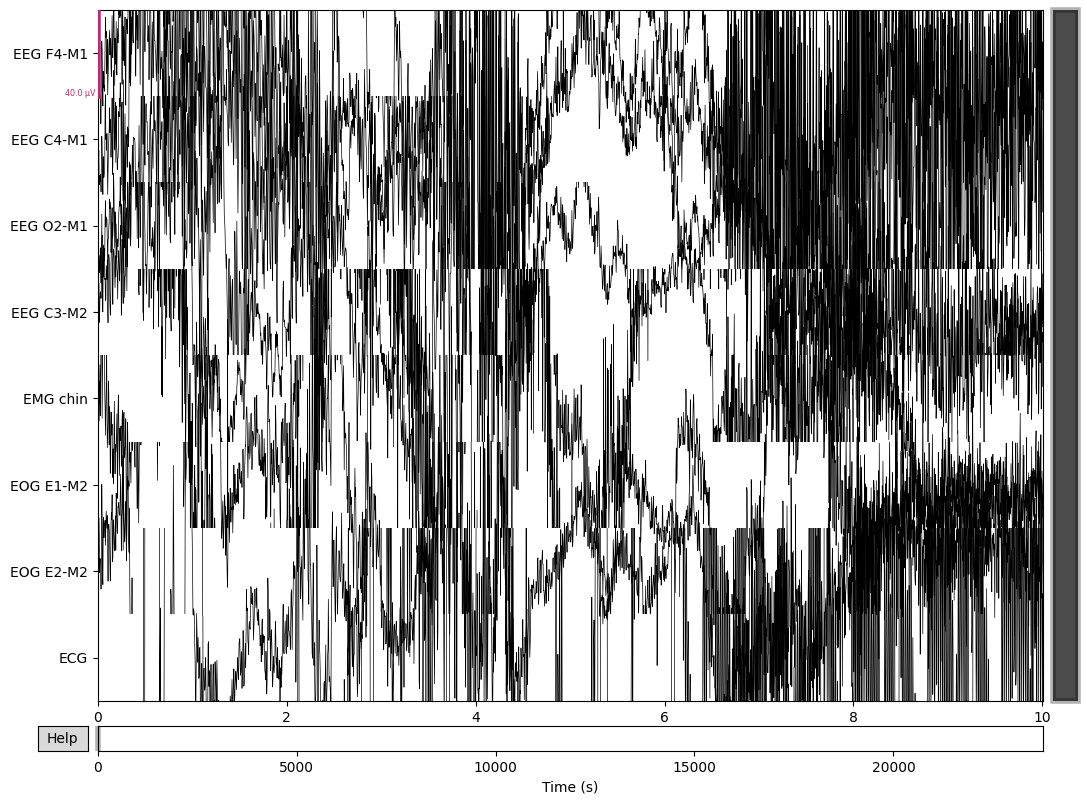

<RawEDF | SN023.edf, 8 x 6004224 (23454.0 s), ~366.5 MB, data loaded>

In [190]:
raw.plot(title='Signals');
total_duration = raw.times[-1] 
#print(raw.times, total_duration) # Get the total duration of the signal
raw.crop(tmin=150, tmax=total_duration - 150)

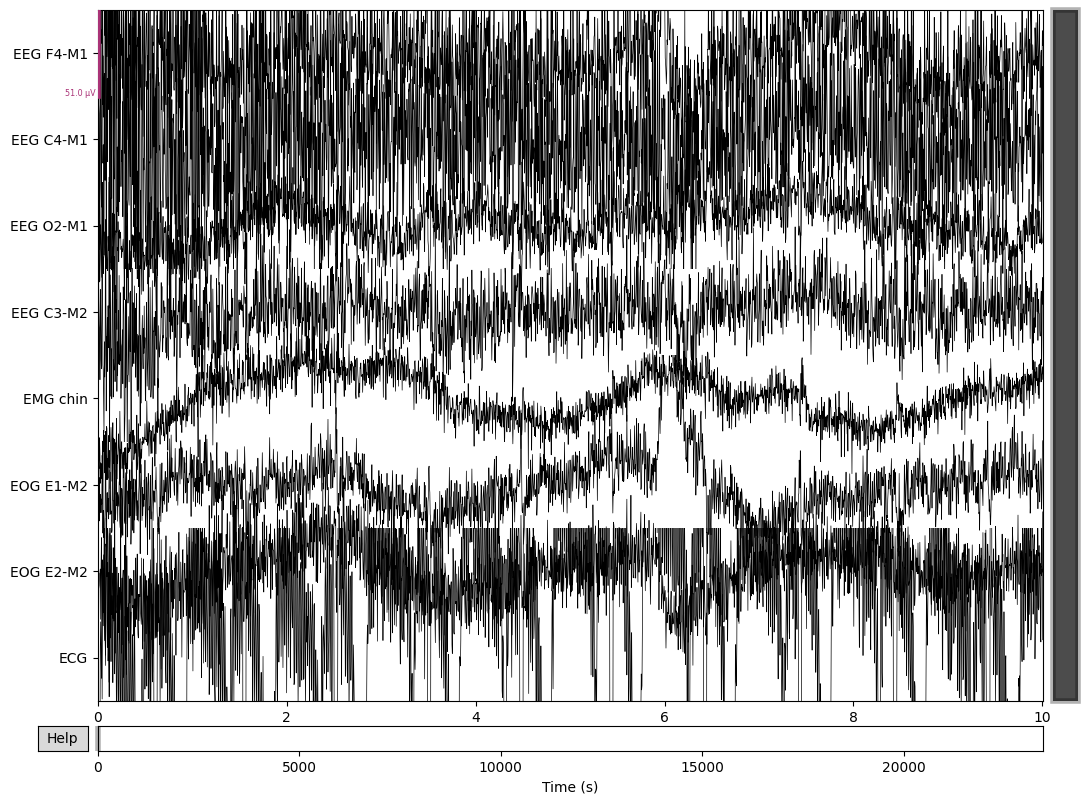

In [191]:
raw.plot(scalings='auto', title='EEG Data (After Cropping 150s)', show=True);

<RawEDF | SN023.edf, 1 x 6004224 (23454.0 s), ~45.8 MB, data loaded>


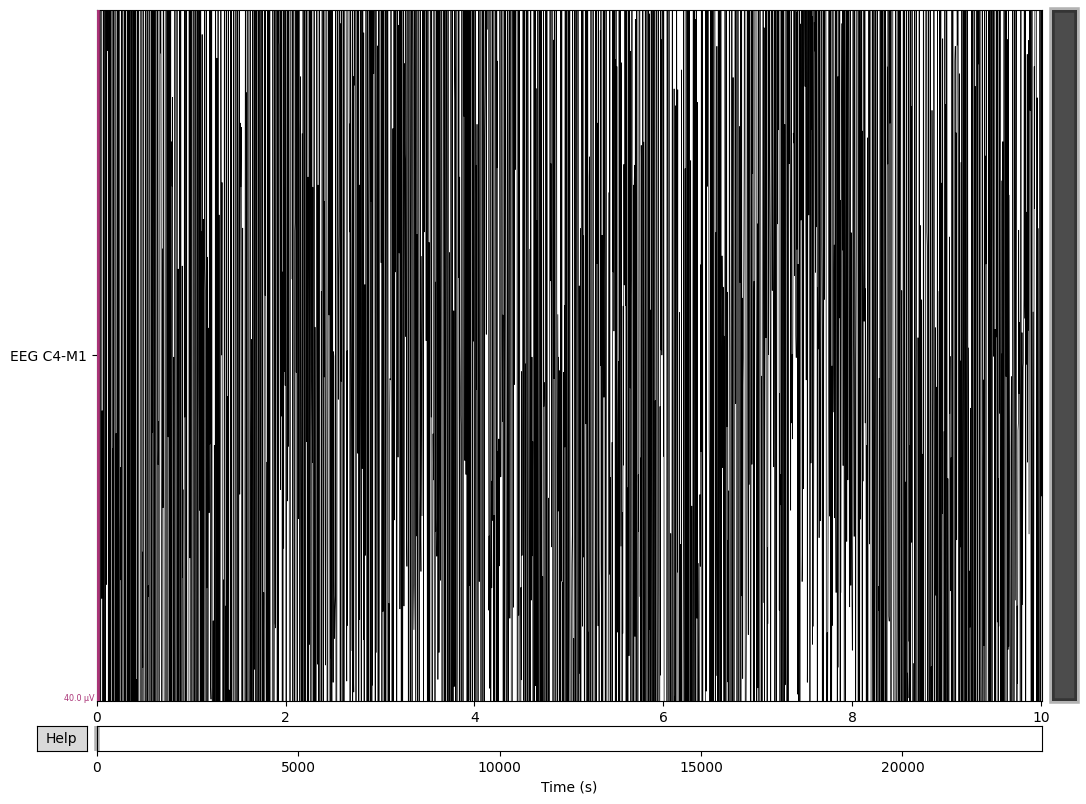

In [192]:
eeg_m1 = raw.copy().pick(['EEG C4-M1'])
print(eeg_m1)
eeg_m1.plot(title='EEG C4-M1');


In [193]:
eeg_m1.filter(0.5, 30, fir_design='firwin')
eeg_m1.resample(100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



<RawEDF | SN023.edf, 1 x 2345400 (23454.0 s), ~17.9 MB, data loaded>

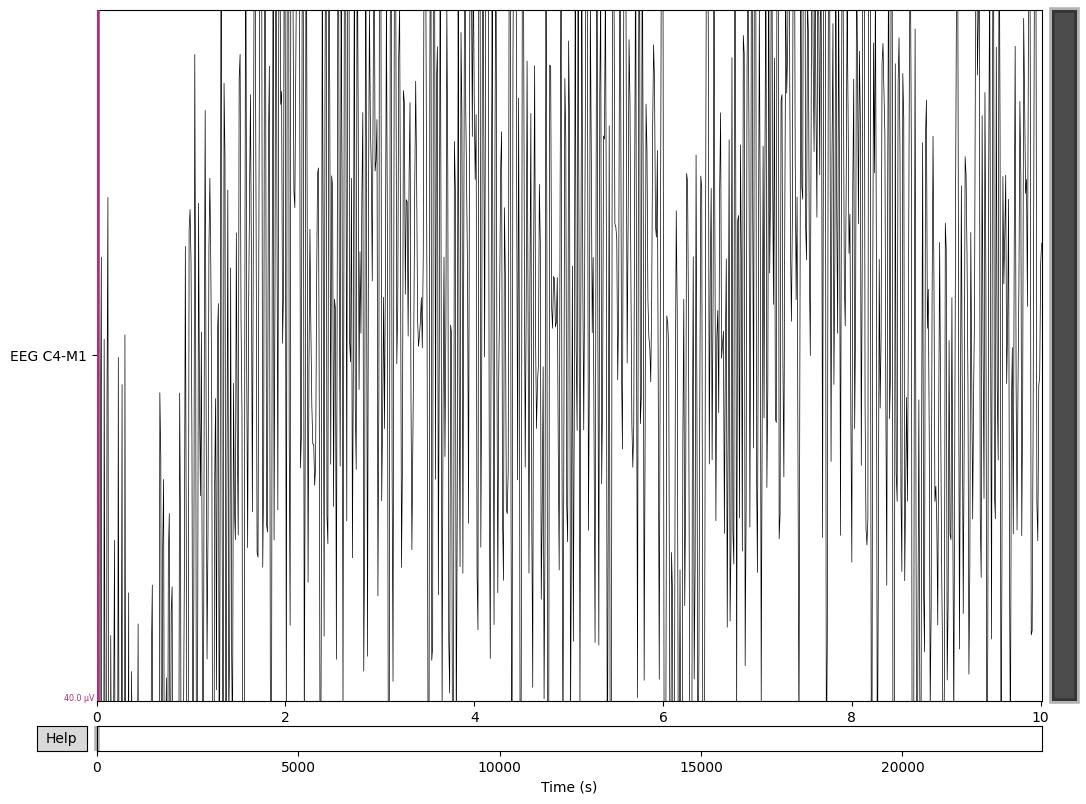

In [194]:
eeg_m1.plot(title='EEG C4-M1');

In [195]:
# ! pip install pandas
import pandas as pd

# Load annotations
annotations_df = pd.read_csv(r'C:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN023_sleepscoring.txt')  # Replace with the path to your file
annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]

# Convert onset and duration to numeric values (in seconds) if needed
annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

# Check the data
print(annotations_df.head())


       Date           Time  Recording onset  Duration      Annotation  \
0  01.01.01       22.51.00             0.00        30   Sleep stage W   
1  01.01.01       22.51.30            30.00        30   Sleep stage W   
2  01.01.01   22.51.36.790            36.79         0      Lights off   
3  01.01.01       22.52.00            60.00        30   Sleep stage W   
4  01.01.01       22.52.30            90.00        30   Sleep stage W   

  Linked channel  
0                 
1                 
2                 
3                 
4                 


In [196]:
# Total duration of the recording after cropping
total_duration = raw.times[-1] - 150 * 2  # After removing 150 seconds from start and end

# Filter annotations to fit within the cropped data range
filtered_annotations_df = annotations_df[
    (annotations_df['Recording onset'] >= 150) &
    (annotations_df['Recording onset'] <= total_duration)
].copy()

# Adjust onset to account for cropping the initial 150 seconds
filtered_annotations_df['Recording onset'] -= 150

print(filtered_annotations_df.head())


        Date       Time  Recording onset  Duration      Annotation  \
6   01.01.01   22.53.30              0.0        30   Sleep stage W   
7   01.01.01   22.54.00             30.0        30   Sleep stage W   
8   01.01.01   22.54.30             60.0        30   Sleep stage W   
9   01.01.01   22.55.00             90.0        30   Sleep stage W   
10  01.01.01   22.55.30            120.0        30   Sleep stage W   

   Linked channel  
6                  
7                  
8                  
9                  
10                 


In [197]:
# Convert to MNE annotations
annotations = mne.Annotations(
    onset=filtered_annotations_df['Recording onset'].values,
    duration=filtered_annotations_df['Duration'].values,
    description=filtered_annotations_df['Annotation'].values
)

# Set the annotations to the raw object
raw.set_annotations(annotations)


<RawEDF | SN023.edf, 8 x 6004224 (23454.0 s), ~366.5 MB, data loaded>

In [198]:
# Bandpass filter and resample
raw.filter(0.5, 30, fir_design='firwin')
raw.resample(100)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



<RawEDF | SN023.edf, 8 x 2345400 (23454.0 s), ~143.2 MB, data loaded>

In [199]:
# Create events from annotations
events, event_id = mne.events_from_annotations(raw)

# Epoch the data based on events
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=30, baseline=None, preload=True)

# Encode the labels for machine learning
labels = epochs.events[:, -1]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)


Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
767 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 767 events and 3001 original time points ...
0 bad epochs dropped


In [200]:
import numpy as np
import pywt

# Define the wavelet transform function
def compute_wavelet_features(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Extract statistics from each wavelet level (mean, std deviation)
    features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    return features

# Get the EEG data from the epochs object
eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)

# Apply wavelet transform on each epoch and extract features
wavelet_features = []

for epoch in eeg_data:
    # Flatten the data for each channel and extract features
    for channel_data in epoch:  # Iterate over each channel in the epoch
        features = compute_wavelet_features(channel_data)  # Process each channel separately
        wavelet_features.append(features)

# Convert to NumPy array for ML
wavelet_features = np.array(wavelet_features)


In [201]:
print(wavelet_features)

[[ 4.02889490e-06  5.83218406e-07  1.25004009e-07 ...  1.36999381e-05
   1.53111467e-05  8.40277081e-06]
 [-8.46549320e-06  1.14281517e-06  7.53579318e-07 ...  1.40876549e-05
   2.24675273e-05  1.30834741e-05]
 [-5.28385382e-07  3.61951345e-08  2.00177398e-08 ...  9.52657331e-06
   9.40564371e-06  4.34377103e-06]
 ...
 [-9.21073801e-07  4.75792402e-07  2.45284322e-07 ...  6.93834428e-06
   4.62293439e-06  1.95745301e-06]
 [ 1.50395743e-06  4.62206868e-07 -6.58363326e-08 ...  4.59092016e-06
   2.99347771e-06  1.59985119e-06]
 [ 1.53552221e-05 -1.23750174e-05  6.07187354e-06 ...  1.96079540e-04
   1.54501138e-04  5.52841806e-05]]


In [202]:
# Reshape wavelet features if needed
n_epochs = eeg_data.shape[0]  # Number of epochs
n_channels = eeg_data.shape[1]  # Number of channels
n_features_per_channel = len(wavelet_features[0])  # Number of wavelet features per channel

# Reshape to (n_epochs, n_channels * n_features_per_channel)
wavelet_features = wavelet_features.reshape(n_epochs, n_channels * n_features_per_channel)
print("Reshaped wavelet features:", wavelet_features.shape)


Reshaped wavelet features: (767, 80)


In [203]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(wavelet_features, labels, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (613, 80)
Test set shape: (154, 80)


In [204]:
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print("Model training completed.")


Model training completed.


In [ ]:
    # Make predictions
    y_pred = clf.predict(X_test)

    # Display accuracy and classification report
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8701298701298701
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.71      0.68      0.69        25
           2       0.92      0.91      0.91        53
           3       0.88      0.94      0.91        16
           4       0.93      0.96      0.94        53

    accuracy                           0.87       154
   macro avg       0.79      0.78      0.78       154
weighted avg       0.87      0.87      0.87       154



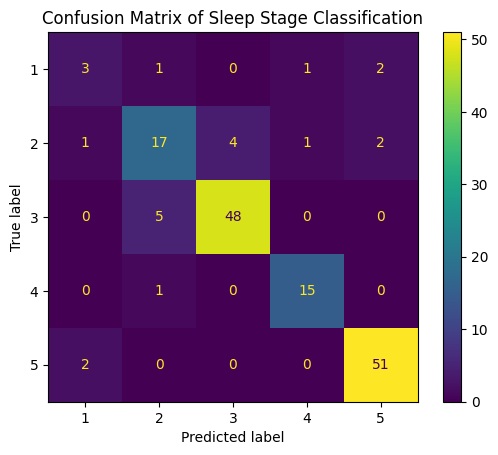

In [206]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Confusion Matrix of Sleep Stage Classification")
plt.show()


In [207]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation
cv_scores = cross_val_score(clf, wavelet_features, labels, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", np.mean(cv_scores))


Cross-Validation Scores: [0.82467532 0.87662338 0.89542484 0.84313725 0.8627451 ]
Average CV Score: 0.8605211781682371
